In [1]:
# This cell imports all necessary libraries for this code
import xarray as xr # library for loading netcdf files
import matplotlib.pyplot as plt # library for plotting 
import numpy as np # libary for working with arrays
import cartopy.crs as ccrs # library for plotting on maps
import matplotlib.ticker as mticker # library for putting axes labels
import math # math library
from scipy.interpolate import griddata

In [2]:
# define some constants
a = 6.37*10**6 # mean radius of the earth (meters)
omega = 7.272*10**-5 # earth rotation rate (rad/s)
pi = math.pi # pi

In [3]:
# This cell defines which file to read

# data that you want to load 
filename = 'era5.33N-48N.162W-135W.2006121400.nc'
# The first thing you want to do is to check what variables are stored in what formats. There are multiple ways to do so.
# method 1) go to terminal and type "ncdump -h filename" where the filename is the actual name of the file that you want to check.
# This will output information about store variables and attributes
# method 2) Check the file here using "xr.open_dataset(filename)".
# When you run this cell, the line below will output information about the data file
datafile = xr.open_dataset(filename)

In [4]:
# This cell loads dimensions of the data
lat = datafile.lat.data # latitude (degress north)
lon = datafile.lon.data # longitude (degrees east)
lev = datafile.lev.data # pressure level (hPa)
time = datafile.time.data # time
print(time)

['2006-12-14T00:00:00.000000000']


In [5]:
# This cell will load variables of the data
# loading one isobaric level (e.g., 850 hPa)
p0 = 850
u=datafile.u.sel(lev=p0).data[0,:,:] # zonal wind (m/s) with dimension lat x lon
v=datafile.v.sel(lev=p0).data[0,:,:] # meridional wind (m/s) with dimension lat x lon
w=datafile.w.sel(lev=p0).data[0,:,:] # vertical velocity (Pa/s)
G=datafile.g.sel(lev=p0).data[0,:,:] # geopotential (m^2 s^-2)
# for all these variables, I am only loading the first time index

# you also need to load u and v at levels above and below to calculate vertical gradients
p1 = lev[np.where(lev==p0)[0]-1] # one pressure level below p0
p2 = lev[np.where(lev==p0)[0]+1] # one pressure level above p0
u_lev1=datafile.u.sel(lev=p1).data[0,:,:] # vertical level below
v_lev1=datafile.v.sel(lev=p1).data[0,:,:] 
u_lev2=datafile.u.sel(lev=p2).data[0,:,:] # vertical level above
v_lev2=datafile.v.sel(lev=p2).data[0,:,:] 

In [6]:
# Define a center of the polar coordinates
# Here, I just subjectively picked a point, but you can define it more objectively (e.g., at the minimum pressure point)
latctr = 41
lonctr = -150
x_polar = np.tile(lon-lonctr,(len(lat),1))*np.transpose(np.tile(2*math.pi*a*np.cos(lat*math.pi/180)/360,(len(lon),1))) # meters
y_polar = np.transpose(np.tile((lat-latctr)*2*math.pi*a/360,(len(lon),1)))
radius = (10**-3)*(x_polar**2+y_polar**2)**0.5 # radius (km)
azimuth_angle = np.arctan2(y_polar,x_polar) # azimuthal angle (radian)

print(radius.shape)

(61, 109)


In [7]:
# find radial and azimuthal wind using cosine direction matrix
C_radial_x = np.cos(azimuth_angle) # [e1-dot-er] projection of x direction to radial direction
C_radial_y = np.sin(azimuth_angle) # [e2-dot-er] projection of y direction to radial direction
C_azimuth_x = -1*np.sin(azimuth_angle) # [e1-dot-etheta] projection of x direction to azimuthal direction
C_azimuth_y = np.cos(azimuth_angle) # [e2-dot-ethta] projection of y direction to azimuthal direction

u_radial = u*C_radial_x+v*C_radial_y #projecting u and v onto radial direction
u_azimuth = u*C_azimuth_x+v*C_azimuth_y # projection onto azimuthal direction

# also find azimuthal wind at levels above and below for calculating vertical advection
u_azimuth_lev1 = u_lev1*C_azimuth_x+v_lev1*C_azimuth_y
u_azimuth_lev2 = u_lev2*C_azimuth_x+v_lev2*C_azimuth_y

In [10]:
# Interpret all variables on uniform radius-azimuth coordinates
# This will make it easier to calculate radial and azimuthal gradients

lon_mesh,lat_mesh = np.meshgrid(lon,lat)

f = 2*omega*np.sin(lat_mesh*2*pi/360) # coriolis parameter

max_radius = np.max(radius) # finding maximum radius
bin_radius = np.arange(0,max_radius+50,50) # radius bins with 100 km interval
bin_theta = np.arange(-180,180,1)

# the variables below are on radius-azimuth coordinates
u_radial_polar = np.zeros((len(bin_radius),len(bin_theta)))*np.nan
u_azimuth_polar = np.zeros((len(bin_radius),len(bin_theta)))*np.nan
u_azimuth_polar_lev1 = np.zeros((len(bin_radius),len(bin_theta)))*np.nan
u_azimuth_polar_lev2 = np.zeros((len(bin_radius),len(bin_theta)))*np.nan
w_polar = np.zeros((len(bin_radius),len(bin_theta)))*np.nan
G_polar = np.zeros((len(bin_radius),len(bin_theta)))*np.nan
f_polar = np.zeros((len(bin_radius),len(bin_theta)))*np.nan
points = np.zeros((len(lat_mesh.flatten()),2))*np.nan
points[:,0]=lat_mesh.flatten()
points[:,1]=lon_mesh.flatten()
for r in range(0,len(bin_radius)-1):
    r0 = bin_radius[r]*10**3
    x_r0 = r0*np.cos(bin_theta*2*pi/360)
    y_r0 = r0*np.sin(bin_theta*2*pi/360)
    lat_r0 = y_r0*(360/(2*pi*a))+latctr
    lon_r0 = x_r0*(360/(2*pi*a*np.cos(lat_r0*2*pi/360)))+lonctr
    u_radial_polar[r,:] = griddata(points, u_radial.flatten(), (lat_r0,lon_r0), method='linear')
    u_azimuth_polar[r,:] = griddata(points, u_azimuth.flatten(), (lat_r0,lon_r0), method='linear')
    u_azimuth_polar_lev1[r,:] = griddata(points, u_azimuth_lev1.flatten(), (lat_r0,lon_r0), method='linear')
    u_azimuth_polar_lev2[r,:] = griddata(points, u_azimuth_lev2.flatten(), (lat_r0,lon_r0), method='linear')
    w_polar[r,:] = griddata(points, w.flatten(), (lat_r0,lon_r0), method='linear')
    G_polar[r,:] = griddata(points, G.flatten(), (lat_r0,lon_r0), method='linear')
    f_polar[r,:] = griddata(points, f.flatten(), (lat_r0,lon_r0), method='linear')


Text(0, 0.5, 'Radius (km)')

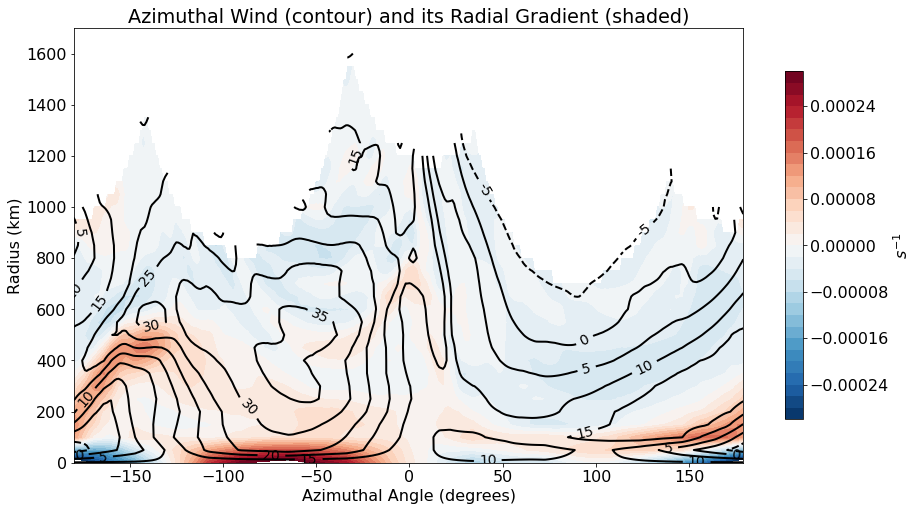

In [16]:
# an example of how to calculate radial and azimuthal gradients
# create meshgrid of azimuthal and radius in radian and meters
theta_mesh,radius_mesh = np.meshgrid(bin_theta*(2*pi/360),bin_radius*10**3)

# radial gradient of azimuthal wind (du_theta/dr)
duazimuth_dr = np.zeros((len(bin_radius),len(bin_theta)))*np.nan
duazimuth_dr[1:-1,:] = (u_azimuth_polar[2:,:]-u_azimuth_polar[0:-2,:])/(radius_mesh[2:,:]-radius_mesh[0:-2,:]) # using centered differencing
duazimuth_dr[0,:]=(u_azimuth_polar[1,:]-u_azimuth_polar[0,:])/(radius_mesh[1,:]-radius_mesh[0,:]) # using forward differencing
duazimuth_dr[-1,:]=(u_azimuth_polar[-1,:]-u_azimuth_polar[-2,:])/(radius_mesh[-1:,:]-radius_mesh[-2,:]) # using backward differencing
# calculate radial advection (-u_r*(du_theta/dr))
adv_radial = -1*u_radial_polar*duazimuth_dr

# one way to check if you have correctly calculated gradients are to plot them!
# Try plotting azimuthal wind and its radial gradient
fig = plt.figure(figsize=(15,8)) # create a figure
plt.rcParams.update({'font.size':16}) # change the font size

# plot filled contours
ticks = np.arange(-30,32,2)*10**-5
plot1 = plt.contourf(bin_theta,bin_radius,duazimuth_dr,ticks,cmap="RdBu_r") # contour dudx
cbar = fig.colorbar(plot1,shrink=0.8) # add a colorbar
cbar.set_label('$s^{-1}$') # add units label to the colorbar
# add line contours
plot2 = plt.contour(bin_theta,bin_radius,u_azimuth_polar,np.arange(-50,50,5),colors='k',linewidths=2) # contour u
plt.clabel(plot2, inline=True, fontsize=14, fmt='%d')
# add title
plt.title('Azimuthal Wind (contour) and its Radial Gradient (shaded)') 
plt.xlabel('Azimuthal Angle (degrees)')
plt.ylabel('Radius (km)')


In [137]:
# In a similar manner, calculate azimuthal advection of azimuthal wind


In [138]:
# an example of how to calculate vertical advection (-w*du/dp)
# calculate vertical gradients with layer above and below
dudp1 = (u_azimuth_polar_lev2-u_azimuth_polar)/(100*(p2-p0)) # du/dp (m s-1 Pa-1) gradient with layer above
dudp2 = (u_azimuth_polar-u_azimuth_polar_lev1)/(100*(p0-p1)) # gradient with layer below
dudp = (dudp1+dudp2)/2 # take average vertical gradient
adv_z = -1*w_polar*dudp


In [140]:
# other terms that you need to calculate are PGF, Centrifugal, and Coriolis
# note: What I loaded here is geopotential height (unit: meters)
# To convert geopotential height to geopotential (unit: m2 s-2), multiply geopotential height with gravity

